In [2]:
#ensure that matplotlib plots inline
%matplotlib inline

import os
import numpy as np
import mvpa2
import nibabel
import pickle
import gzip
from mvpa2.suite import *
from nilearn.image import resample_img
from nilearn import image
from scipy.signal import resample

In [3]:
bold_fname = os.path.join('..', 'data', 'qub', '4Dw.nii')
mask_fname = os.path.join('..', 'data', 'qub', 'struct', 'final_mask_w.hdr')

In [4]:
original_dataset = fmri_dataset(bold_fname, mask=mask_fname)

In [5]:
#print the shape of the original dataset
original_dataset.shape

(1351, 65159)

In [6]:
#get the trajectory
with open('..\\data\\story\\smoothedTrajectoriesDifferentWindowSizes\\smoothTrajRawValenceMean_win200.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    original_trajectory = u.load()

In [7]:
#downsample the trajectory to fit match the number of fMRI sample
resampled_trajectory = resample(original_trajectory, len(original_dataset.samples))

In [11]:
#print the size of the new vs old trajectory
print("Old: ")
print(len(original_trajectory))
print("New: ")
print(len(resampled_trajectory))

Old: 
5176
New: 
1351


In [57]:
array1 = original_dataset[:, 0].samples.ravel()
array1

memmap([31, 32, 32, ..., 30, 30, 30], dtype=int16)

In [58]:
array2 = resampled_trajectory.ravel()
array2

array([-0.14046407,  0.01457895, -0.03334154, ...,  1.46519454,
       -0.08947645, -0.39459833])

In [61]:
import numpy

# array1 = [1,4,6]
# array2 = [1,2,3]
numpy.corrcoef(array1, array2)[1,0]

0.026243206974000507

In [62]:
#get the correlation of a random row
from scipy.stats.stats import pearsonr

print(pearsonr(array1,array2))

TypeError: tuple indices must be integers or slices, not tuple

In [136]:
%timeit
#work out the results of the correlation of each pixel/feature over time
correlation_results = []

range_max = original_dataset.nfeatures

#convert the story trajectory to a list
trajectory_list = resampled_trajectory.ravel()

for num in range(0, range_max):
    sample_list = original_dataset[:, num].samples.ravel()
    correlation_result = numpy.corrcoef(trajectory_list, sample_list)[1,0]
    correlation_results.append(correlation_result)
    
print(len(correlation_results))

65159


E:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


In [137]:
#print the max correlation
print("max correlation found:")
max(correlation_results)

max correlation found:


0.48257036821967486

In [138]:
#replace NaN with 0s
correlation_results = np.nan_to_num(correlation_results)

In [139]:
#check to ensure we have no NaN results
np.isnan(np.sum(correlation_results))

False

In [140]:
#use numpy to convert the array to a 2d array - enabling us to create a Dataset
correlation_matrix = np.reshape(correlation_results,(-1,len(correlation_results)))

In [141]:
#print the shape of the correlation matrix
correlation_matrix.shape

(1, 65159)

In [142]:
#create a dataset from the correlation matrix
correlation_dataset = Dataset(correlation_matrix)

#print the shape of the correlation dataset - should match the original amount of features
correlation_dataset.shape

(1, 65159)

In [143]:
#map the correlation dataset back to the original dataset
overlay_data = map2nifti(original_dataset, correlation_dataset)

In [144]:
overlay_data.to_filename('mytest.nii.gz')

In [145]:
#load the high-res anatomy - this needs to be downsampled to fit the resolution of our data
original_anatomy = nibabel.load(os.path.join('..', 'data', 'qub', 'struct', 'cos005a1001.hdr'))

#we will use the first volumne/sample from the bold data to 
bold_data_sample = image.index_img(bold_fname, 0)

#resample the original anatomy to meet the bold data
resampled_anatomy = resample_img(original_anatomy,target_affine = bold_data_sample.get_affine(), target_shape=bold_data_sample.shape)

In [179]:
#http://matplotlib.org/examples/color/colormaps_reference.html
mri_args = {
    'background' : resampled_anatomy,
    'cmap_bg' : 'gray',
    'cmap_overlay' : 'PiYG', # YlOrRd_r # pl.cm.autumn
    'interactive' : cfg.getboolean('examples', 'interactive', True),
    }

E:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


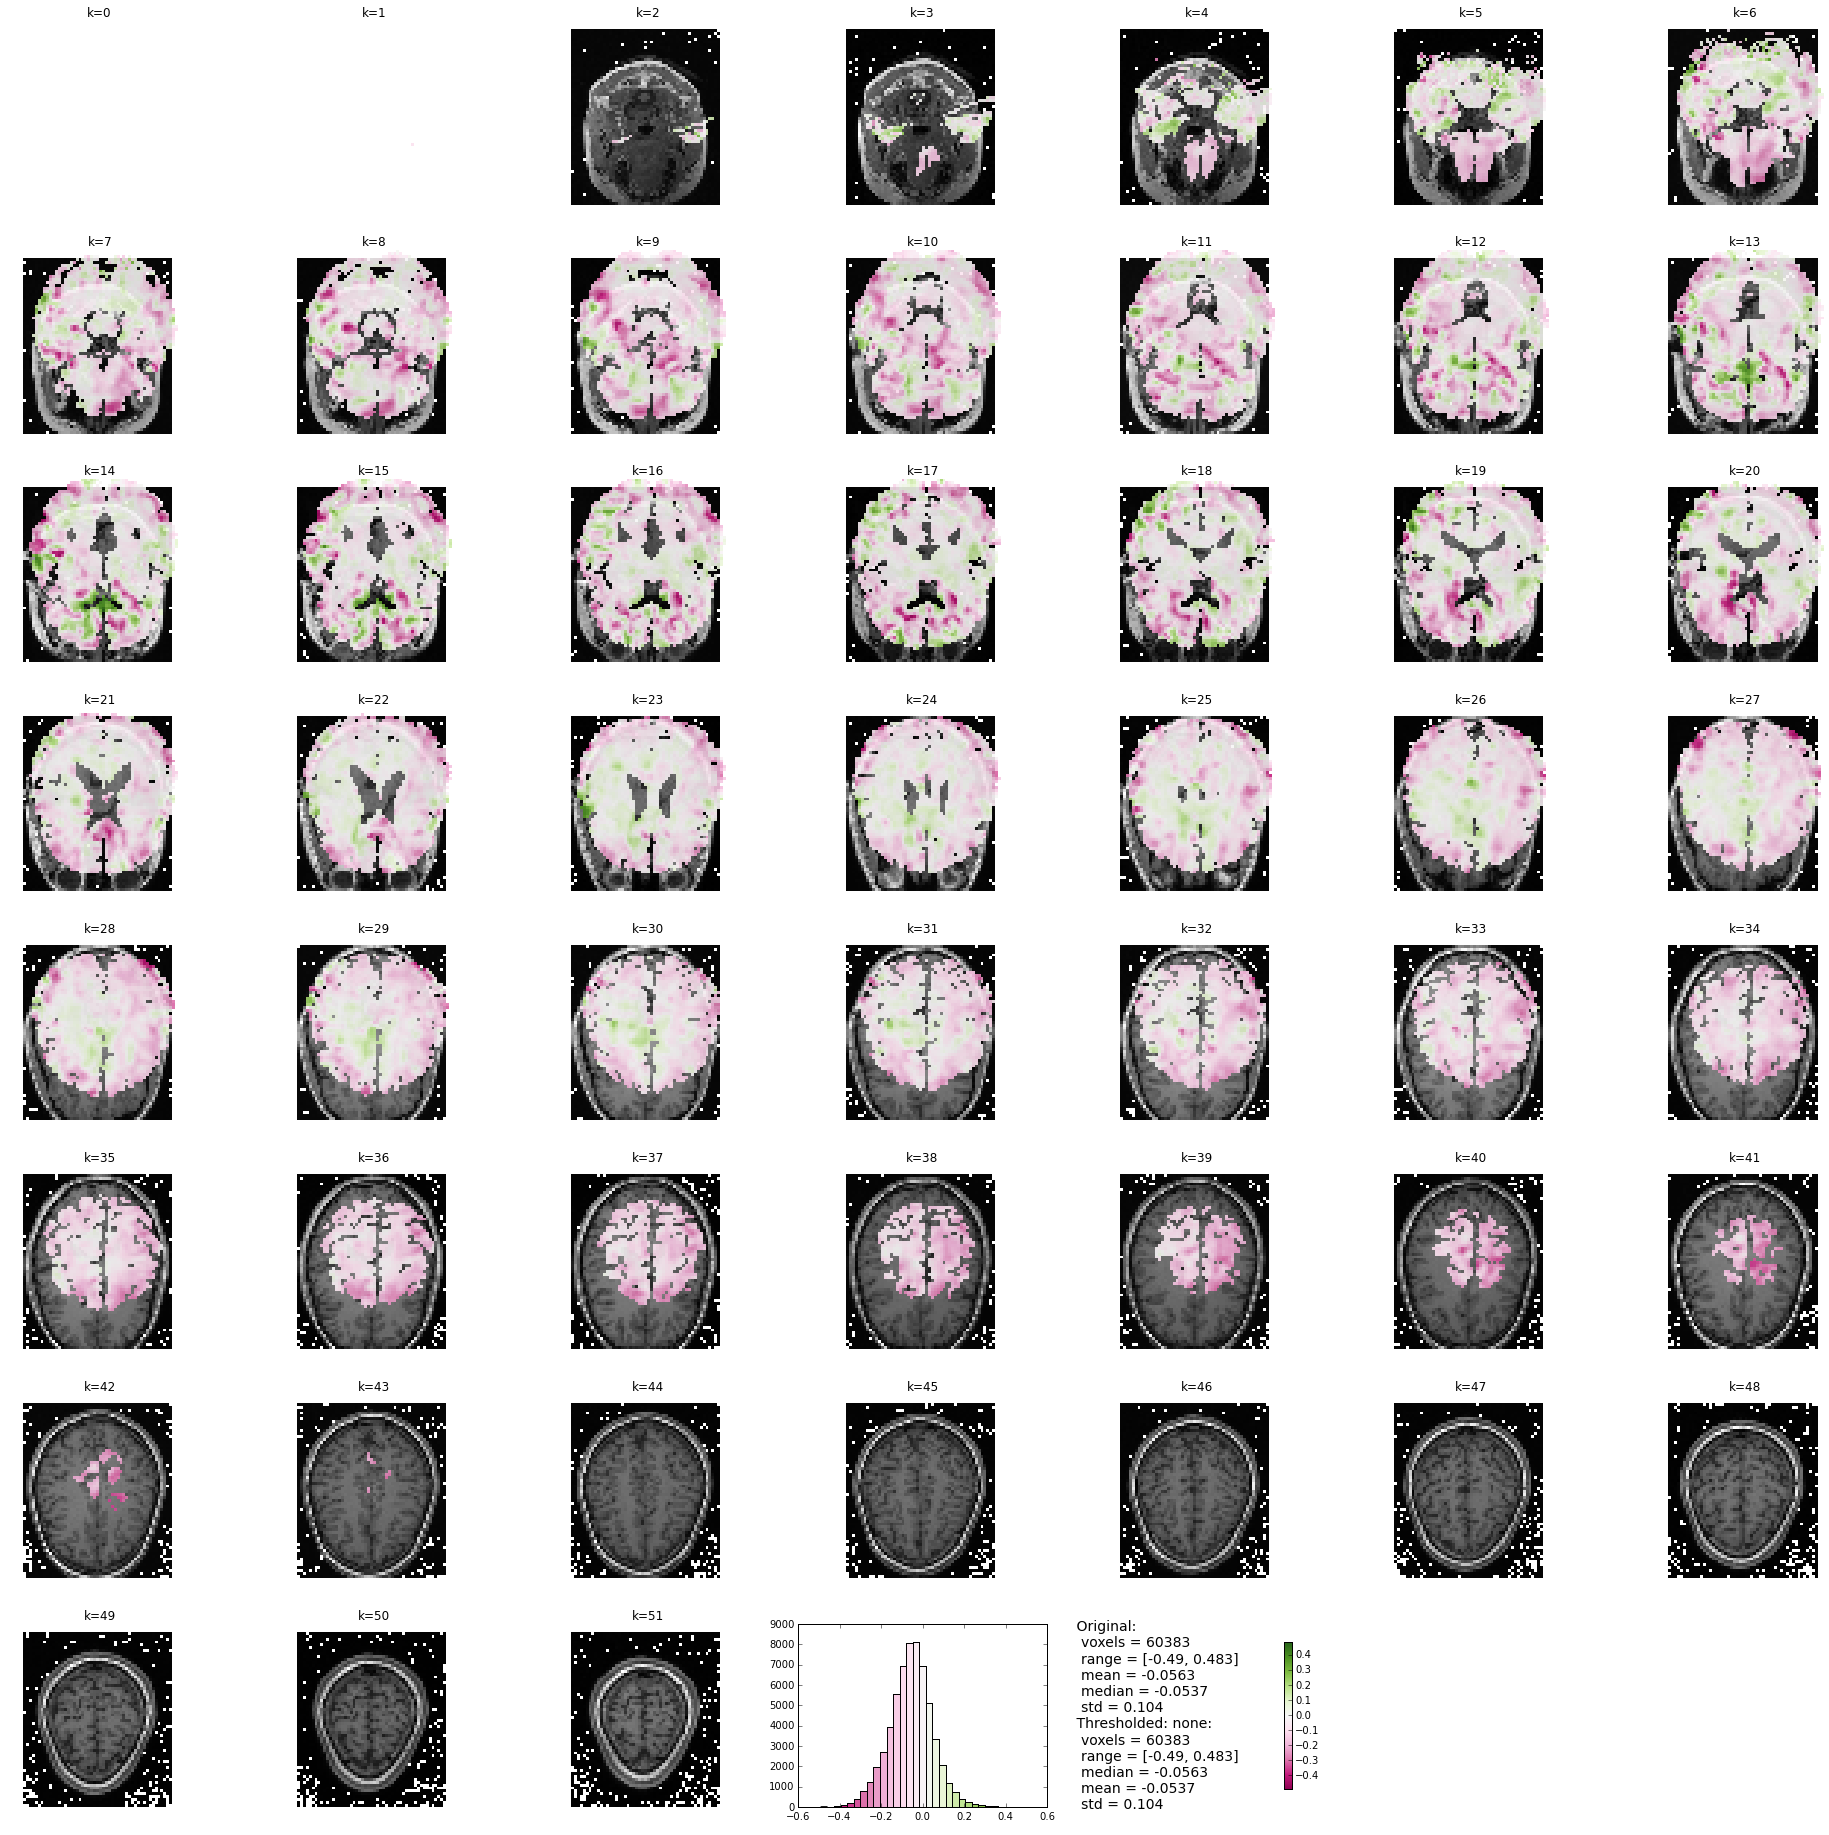

In [180]:
#draw an overlay
from brainCorrelationPlotter import plot_lightbox

fig = plot_lightbox(overlay=overlay_data, vlim=(-1.0, 1.0), do_stretch_colors=True, **mri_args)